In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


Using TensorFlow backend.


In [2]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = 'train/'
path_test = 'test/'

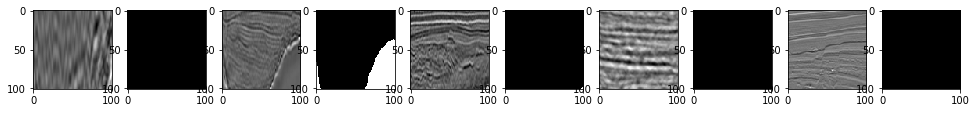

In [3]:
# take some data to build a model, seeing whether it generalizes 
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('train/images/' + img_name + '.png')
    img_mask = load_img('train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show() #we discover that the model can identify patches without salt

In [4]:
# modeling our data into a Unet shape (it should be a power of 2)
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [5]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


C:\Users\NnamdiAffia\Anaconda3\envs\stackgan3.5\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


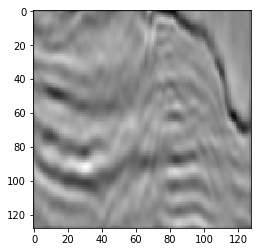

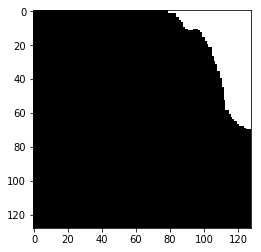

In [6]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [8]:
# Build U-Net model
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [9]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30


1472/3600 [===========>..................] - ETA: 23:42 - loss: 0.6856 - mean_iou: 0.0000e+0 - ETA: 12:58 - loss: 0.6853 - mean_iou: 0.1616    - ETA: 9:23 - loss: 0.6629 - mean_iou: 0.207 - ETA: 7:36 - loss: 0.6469 - mean_iou: 0.23 - ETA: 6:31 - loss: 0.6229 - mean_iou: 0.26 - ETA: 5:49 - loss: 0.6250 - mean_iou: 0.27 - ETA: 5:18 - loss: 0.6208 - mean_iou: 0.29 - ETA: 4:55 - loss: 0.6026 - mean_iou: 0.30 - ETA: 4:37 - loss: 0.6064 - mean_iou: 0.31 - ETA: 4:22 - loss: 0.6045 - mean_iou: 0.31 - ETA: 4:09 - loss: 0.6027 - mean_iou: 0.32 - ETA: 3:59 - loss: 0.5988 - mean_iou: 0.32 - ETA: 3:50 - loss: 0.6004 - mean_iou: 0.32 - ETA: 3:43 - loss: 0.5924 - mean_iou: 0.33 - ETA: 3:36 - loss: 0.6025 - mean_iou: 0.33 - ETA: 3:30 - loss: 0.6053 - mean_iou: 0.33 - ETA: 3:25 - loss: 0.6010 - mean_iou: 0.34 - ETA: 3:20 - loss: 0.6087 - mean_iou: 0.34 - ETA: 3:16 - loss: 0.5974 - mean_iou: 0.34 - ETA: 3:12 - loss: 0.5881 - mean_iou: 0.34 - ETA: 3:09 - loss: 0.5848 - mean_iou: 0.34 - ETA: 3:06 - loss: 

3600/3600 [==============================] - ETA: 25s - loss: 0.5564 - mean_iou: 0.374 - ETA: 24s - loss: 0.5560 - mean_iou: 0.374 - ETA: 24s - loss: 0.5555 - mean_iou: 0.374 - ETA: 24s - loss: 0.5554 - mean_iou: 0.374 - ETA: 23s - loss: 0.5557 - mean_iou: 0.374 - ETA: 23s - loss: 0.5553 - mean_iou: 0.374 - ETA: 23s - loss: 0.5551 - mean_iou: 0.374 - ETA: 23s - loss: 0.5549 - mean_iou: 0.374 - ETA: 22s - loss: 0.5549 - mean_iou: 0.374 - ETA: 22s - loss: 0.5545 - mean_iou: 0.374 - ETA: 22s - loss: 0.5545 - mean_iou: 0.374 - ETA: 21s - loss: 0.5544 - mean_iou: 0.374 - ETA: 21s - loss: 0.5544 - mean_iou: 0.374 - ETA: 21s - loss: 0.5536 - mean_iou: 0.374 - ETA: 20s - loss: 0.5535 - mean_iou: 0.374 - ETA: 20s - loss: 0.5531 - mean_iou: 0.374 - ETA: 20s - loss: 0.5536 - mean_iou: 0.374 - ETA: 19s - loss: 0.5538 - mean_iou: 0.374 - ETA: 19s - loss: 0.5532 - mean_iou: 0.374 - ETA: 19s - loss: 0.5527 - mean_iou: 0.374 - ETA: 18s - loss: 0.5523 - mean_iou: 0.374 - ETA: 18s - loss: 0.5523 - mean_

1488/3600 [===========>..................] - ETA: 2:08 - loss: 0.5367 - mean_iou: 0.38 - ETA: 2:14 - loss: 0.5994 - mean_iou: 0.38 - ETA: 2:17 - loss: 0.6021 - mean_iou: 0.38 - ETA: 2:19 - loss: 0.7197 - mean_iou: 0.38 - ETA: 2:20 - loss: 0.6209 - mean_iou: 0.38 - ETA: 2:20 - loss: 0.6048 - mean_iou: 0.38 - ETA: 2:20 - loss: 0.6011 - mean_iou: 0.38 - ETA: 2:20 - loss: 0.5826 - mean_iou: 0.38 - ETA: 2:21 - loss: 0.5847 - mean_iou: 0.38 - ETA: 2:22 - loss: 0.5698 - mean_iou: 0.38 - ETA: 2:22 - loss: 0.5734 - mean_iou: 0.38 - ETA: 2:22 - loss: 0.5697 - mean_iou: 0.38 - ETA: 2:23 - loss: 0.5667 - mean_iou: 0.38 - ETA: 2:23 - loss: 0.5609 - mean_iou: 0.38 - ETA: 2:23 - loss: 0.5585 - mean_iou: 0.38 - ETA: 2:22 - loss: 0.5543 - mean_iou: 0.38 - ETA: 2:22 - loss: 0.5540 - mean_iou: 0.38 - ETA: 2:21 - loss: 0.5488 - mean_iou: 0.38 - ETA: 2:21 - loss: 0.5413 - mean_iou: 0.38 - ETA: 2:21 - loss: 0.5382 - mean_iou: 0.38 - ETA: 2:20 - loss: 0.5297 - mean_iou: 0.38 - ETA: 2:20 - loss: 0.5237 - mean

3600/3600 [==============================] - ETA: 25s - loss: 0.4181 - mean_iou: 0.403 - ETA: 24s - loss: 0.4178 - mean_iou: 0.403 - ETA: 24s - loss: 0.4173 - mean_iou: 0.403 - ETA: 24s - loss: 0.4173 - mean_iou: 0.403 - ETA: 23s - loss: 0.4169 - mean_iou: 0.403 - ETA: 23s - loss: 0.4165 - mean_iou: 0.403 - ETA: 23s - loss: 0.4163 - mean_iou: 0.403 - ETA: 22s - loss: 0.4156 - mean_iou: 0.403 - ETA: 22s - loss: 0.4148 - mean_iou: 0.404 - ETA: 22s - loss: 0.4144 - mean_iou: 0.404 - ETA: 21s - loss: 0.4148 - mean_iou: 0.404 - ETA: 21s - loss: 0.4145 - mean_iou: 0.404 - ETA: 21s - loss: 0.4141 - mean_iou: 0.404 - ETA: 20s - loss: 0.4139 - mean_iou: 0.404 - ETA: 20s - loss: 0.4135 - mean_iou: 0.404 - ETA: 20s - loss: 0.4130 - mean_iou: 0.404 - ETA: 19s - loss: 0.4131 - mean_iou: 0.404 - ETA: 19s - loss: 0.4129 - mean_iou: 0.404 - ETA: 19s - loss: 0.4138 - mean_iou: 0.404 - ETA: 18s - loss: 0.4143 - mean_iou: 0.404 - ETA: 18s - loss: 0.4138 - mean_iou: 0.404 - ETA: 18s - loss: 0.4138 - mean_

1488/3600 [===========>..................] - ETA: 2:18 - loss: 0.7021 - mean_iou: 0.43 - ETA: 2:24 - loss: 0.4696 - mean_iou: 0.43 - ETA: 2:31 - loss: 0.3623 - mean_iou: 0.43 - ETA: 2:29 - loss: 0.3961 - mean_iou: 0.43 - ETA: 2:27 - loss: 0.4184 - mean_iou: 0.43 - ETA: 2:26 - loss: 0.4133 - mean_iou: 0.43 - ETA: 2:25 - loss: 0.4022 - mean_iou: 0.43 - ETA: 2:26 - loss: 0.3804 - mean_iou: 0.43 - ETA: 2:25 - loss: 0.3728 - mean_iou: 0.43 - ETA: 2:24 - loss: 0.3632 - mean_iou: 0.43 - ETA: 2:24 - loss: 0.4004 - mean_iou: 0.43 - ETA: 2:24 - loss: 0.3957 - mean_iou: 0.44 - ETA: 2:23 - loss: 0.3907 - mean_iou: 0.44 - ETA: 2:22 - loss: 0.3791 - mean_iou: 0.44 - ETA: 2:22 - loss: 0.3779 - mean_iou: 0.44 - ETA: 2:21 - loss: 0.3790 - mean_iou: 0.44 - ETA: 2:21 - loss: 0.3712 - mean_iou: 0.44 - ETA: 2:20 - loss: 0.3613 - mean_iou: 0.44 - ETA: 2:19 - loss: 0.3539 - mean_iou: 0.44 - ETA: 2:19 - loss: 0.3555 - mean_iou: 0.44 - ETA: 2:20 - loss: 0.3485 - mean_iou: 0.44 - ETA: 2:19 - loss: 0.3640 - mean

3600/3600 [==============================] - ETA: 25s - loss: 0.3505 - mean_iou: 0.461 - ETA: 25s - loss: 0.3507 - mean_iou: 0.461 - ETA: 25s - loss: 0.3506 - mean_iou: 0.461 - ETA: 24s - loss: 0.3503 - mean_iou: 0.461 - ETA: 24s - loss: 0.3503 - mean_iou: 0.461 - ETA: 24s - loss: 0.3500 - mean_iou: 0.461 - ETA: 23s - loss: 0.3501 - mean_iou: 0.461 - ETA: 23s - loss: 0.3505 - mean_iou: 0.461 - ETA: 23s - loss: 0.3500 - mean_iou: 0.461 - ETA: 22s - loss: 0.3497 - mean_iou: 0.461 - ETA: 22s - loss: 0.3490 - mean_iou: 0.461 - ETA: 22s - loss: 0.3493 - mean_iou: 0.462 - ETA: 21s - loss: 0.3487 - mean_iou: 0.462 - ETA: 21s - loss: 0.3485 - mean_iou: 0.462 - ETA: 21s - loss: 0.3479 - mean_iou: 0.462 - ETA: 20s - loss: 0.3473 - mean_iou: 0.462 - ETA: 20s - loss: 0.3468 - mean_iou: 0.462 - ETA: 20s - loss: 0.3465 - mean_iou: 0.462 - ETA: 19s - loss: 0.3459 - mean_iou: 0.462 - ETA: 19s - loss: 0.3454 - mean_iou: 0.462 - ETA: 19s - loss: 0.3449 - mean_iou: 0.462 - ETA: 18s - loss: 0.3447 - mean_

1488/3600 [===========>..................] - ETA: 2:41 - loss: 0.2167 - mean_iou: 0.49 - ETA: 2:40 - loss: 0.2559 - mean_iou: 0.49 - ETA: 2:41 - loss: 0.2849 - mean_iou: 0.49 - ETA: 2:39 - loss: 0.2958 - mean_iou: 0.49 - ETA: 2:38 - loss: 0.3225 - mean_iou: 0.49 - ETA: 2:39 - loss: 0.3197 - mean_iou: 0.49 - ETA: 2:39 - loss: 0.3449 - mean_iou: 0.49 - ETA: 2:37 - loss: 0.3416 - mean_iou: 0.49 - ETA: 2:38 - loss: 0.3456 - mean_iou: 0.49 - ETA: 2:37 - loss: 0.3316 - mean_iou: 0.49 - ETA: 2:37 - loss: 0.3308 - mean_iou: 0.49 - ETA: 2:37 - loss: 0.3451 - mean_iou: 0.49 - ETA: 2:37 - loss: 0.3400 - mean_iou: 0.49 - ETA: 2:36 - loss: 0.3505 - mean_iou: 0.49 - ETA: 2:35 - loss: 0.3374 - mean_iou: 0.49 - ETA: 2:34 - loss: 0.3277 - mean_iou: 0.49 - ETA: 2:33 - loss: 0.3138 - mean_iou: 0.49 - ETA: 2:32 - loss: 0.3221 - mean_iou: 0.49 - ETA: 2:31 - loss: 0.3214 - mean_iou: 0.49 - ETA: 2:31 - loss: 0.3217 - mean_iou: 0.49 - ETA: 2:30 - loss: 0.3367 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.3339 - mean

3600/3600 [==============================] - ETA: 26s - loss: 0.2933 - mean_iou: 0.509 - ETA: 25s - loss: 0.2936 - mean_iou: 0.509 - ETA: 25s - loss: 0.2932 - mean_iou: 0.510 - ETA: 25s - loss: 0.2929 - mean_iou: 0.510 - ETA: 24s - loss: 0.2934 - mean_iou: 0.510 - ETA: 24s - loss: 0.2930 - mean_iou: 0.510 - ETA: 24s - loss: 0.2933 - mean_iou: 0.510 - ETA: 23s - loss: 0.2935 - mean_iou: 0.510 - ETA: 23s - loss: 0.2933 - mean_iou: 0.510 - ETA: 23s - loss: 0.2932 - mean_iou: 0.510 - ETA: 22s - loss: 0.2937 - mean_iou: 0.510 - ETA: 22s - loss: 0.2934 - mean_iou: 0.510 - ETA: 22s - loss: 0.2939 - mean_iou: 0.510 - ETA: 21s - loss: 0.2937 - mean_iou: 0.510 - ETA: 21s - loss: 0.2941 - mean_iou: 0.510 - ETA: 21s - loss: 0.2939 - mean_iou: 0.510 - ETA: 20s - loss: 0.2942 - mean_iou: 0.510 - ETA: 20s - loss: 0.2945 - mean_iou: 0.510 - ETA: 20s - loss: 0.2942 - mean_iou: 0.510 - ETA: 19s - loss: 0.2944 - mean_iou: 0.510 - ETA: 19s - loss: 0.2947 - mean_iou: 0.510 - ETA: 19s - loss: 0.2943 - mean_

1488/3600 [===========>..................] - ETA: 2:41 - loss: 0.2471 - mean_iou: 0.53 - ETA: 2:45 - loss: 0.1879 - mean_iou: 0.53 - ETA: 2:42 - loss: 0.1700 - mean_iou: 0.53 - ETA: 2:45 - loss: 0.2728 - mean_iou: 0.53 - ETA: 2:42 - loss: 0.3063 - mean_iou: 0.53 - ETA: 2:38 - loss: 0.3509 - mean_iou: 0.53 - ETA: 2:36 - loss: 0.3341 - mean_iou: 0.53 - ETA: 2:35 - loss: 0.3138 - mean_iou: 0.53 - ETA: 2:34 - loss: 0.3182 - mean_iou: 0.53 - ETA: 2:32 - loss: 0.3046 - mean_iou: 0.53 - ETA: 2:32 - loss: 0.2898 - mean_iou: 0.53 - ETA: 2:31 - loss: 0.2807 - mean_iou: 0.53 - ETA: 2:30 - loss: 0.2758 - mean_iou: 0.53 - ETA: 2:29 - loss: 0.2742 - mean_iou: 0.53 - ETA: 2:28 - loss: 0.2662 - mean_iou: 0.53 - ETA: 2:28 - loss: 0.2707 - mean_iou: 0.53 - ETA: 2:27 - loss: 0.2601 - mean_iou: 0.53 - ETA: 2:27 - loss: 0.2616 - mean_iou: 0.53 - ETA: 2:26 - loss: 0.2610 - mean_iou: 0.53 - ETA: 2:26 - loss: 0.2713 - mean_iou: 0.53 - ETA: 2:26 - loss: 0.2676 - mean_iou: 0.53 - ETA: 2:25 - loss: 0.2637 - mean

3600/3600 [==============================] - ETA: 27s - loss: 0.2772 - mean_iou: 0.548 - ETA: 26s - loss: 0.2776 - mean_iou: 0.548 - ETA: 26s - loss: 0.2770 - mean_iou: 0.548 - ETA: 25s - loss: 0.2777 - mean_iou: 0.548 - ETA: 25s - loss: 0.2776 - mean_iou: 0.548 - ETA: 25s - loss: 0.2773 - mean_iou: 0.548 - ETA: 24s - loss: 0.2771 - mean_iou: 0.548 - ETA: 24s - loss: 0.2769 - mean_iou: 0.548 - ETA: 24s - loss: 0.2765 - mean_iou: 0.548 - ETA: 23s - loss: 0.2775 - mean_iou: 0.548 - ETA: 23s - loss: 0.2784 - mean_iou: 0.548 - ETA: 23s - loss: 0.2781 - mean_iou: 0.548 - ETA: 22s - loss: 0.2781 - mean_iou: 0.548 - ETA: 22s - loss: 0.2780 - mean_iou: 0.548 - ETA: 22s - loss: 0.2782 - mean_iou: 0.548 - ETA: 21s - loss: 0.2777 - mean_iou: 0.548 - ETA: 21s - loss: 0.2777 - mean_iou: 0.548 - ETA: 21s - loss: 0.2776 - mean_iou: 0.548 - ETA: 20s - loss: 0.2777 - mean_iou: 0.548 - ETA: 20s - loss: 0.2772 - mean_iou: 0.548 - ETA: 19s - loss: 0.2785 - mean_iou: 0.548 - ETA: 19s - loss: 0.2781 - mean_

1488/3600 [===========>..................] - ETA: 2:42 - loss: 0.2488 - mean_iou: 0.56 - ETA: 2:44 - loss: 0.3418 - mean_iou: 0.56 - ETA: 2:41 - loss: 0.3337 - mean_iou: 0.56 - ETA: 2:42 - loss: 0.2941 - mean_iou: 0.56 - ETA: 2:41 - loss: 0.2650 - mean_iou: 0.56 - ETA: 2:40 - loss: 0.2402 - mean_iou: 0.56 - ETA: 2:39 - loss: 0.2759 - mean_iou: 0.56 - ETA: 2:37 - loss: 0.2569 - mean_iou: 0.56 - ETA: 2:36 - loss: 0.2818 - mean_iou: 0.56 - ETA: 2:36 - loss: 0.2906 - mean_iou: 0.56 - ETA: 2:37 - loss: 0.2779 - mean_iou: 0.56 - ETA: 2:37 - loss: 0.2775 - mean_iou: 0.56 - ETA: 2:36 - loss: 0.2785 - mean_iou: 0.56 - ETA: 2:36 - loss: 0.2710 - mean_iou: 0.56 - ETA: 2:35 - loss: 0.2791 - mean_iou: 0.56 - ETA: 2:34 - loss: 0.2808 - mean_iou: 0.56 - ETA: 2:34 - loss: 0.2799 - mean_iou: 0.56 - ETA: 2:33 - loss: 0.2756 - mean_iou: 0.56 - ETA: 2:33 - loss: 0.2742 - mean_iou: 0.56 - ETA: 2:32 - loss: 0.2672 - mean_iou: 0.56 - ETA: 2:32 - loss: 0.2597 - mean_iou: 0.56 - ETA: 2:32 - loss: 0.2643 - mean

3600/3600 [==============================] - ETA: 26s - loss: 0.2492 - mean_iou: 0.579 - ETA: 26s - loss: 0.2490 - mean_iou: 0.579 - ETA: 25s - loss: 0.2494 - mean_iou: 0.579 - ETA: 25s - loss: 0.2498 - mean_iou: 0.579 - ETA: 25s - loss: 0.2498 - mean_iou: 0.579 - ETA: 24s - loss: 0.2496 - mean_iou: 0.579 - ETA: 24s - loss: 0.2497 - mean_iou: 0.579 - ETA: 24s - loss: 0.2501 - mean_iou: 0.579 - ETA: 23s - loss: 0.2500 - mean_iou: 0.579 - ETA: 23s - loss: 0.2502 - mean_iou: 0.579 - ETA: 22s - loss: 0.2508 - mean_iou: 0.579 - ETA: 22s - loss: 0.2505 - mean_iou: 0.579 - ETA: 22s - loss: 0.2506 - mean_iou: 0.579 - ETA: 21s - loss: 0.2502 - mean_iou: 0.579 - ETA: 21s - loss: 0.2503 - mean_iou: 0.579 - ETA: 21s - loss: 0.2501 - mean_iou: 0.579 - ETA: 20s - loss: 0.2500 - mean_iou: 0.580 - ETA: 20s - loss: 0.2504 - mean_iou: 0.580 - ETA: 20s - loss: 0.2504 - mean_iou: 0.580 - ETA: 19s - loss: 0.2503 - mean_iou: 0.580 - ETA: 19s - loss: 0.2514 - mean_iou: 0.580 - ETA: 19s - loss: 0.2512 - mean_

1488/3600 [===========>..................] - ETA: 2:28 - loss: 0.2604 - mean_iou: 0.59 - ETA: 2:31 - loss: 0.3528 - mean_iou: 0.59 - ETA: 2:28 - loss: 0.4045 - mean_iou: 0.59 - ETA: 2:27 - loss: 0.3907 - mean_iou: 0.59 - ETA: 2:28 - loss: 0.3771 - mean_iou: 0.59 - ETA: 2:27 - loss: 0.3324 - mean_iou: 0.59 - ETA: 2:27 - loss: 0.3151 - mean_iou: 0.59 - ETA: 2:27 - loss: 0.3242 - mean_iou: 0.59 - ETA: 2:26 - loss: 0.3280 - mean_iou: 0.59 - ETA: 2:26 - loss: 0.3227 - mean_iou: 0.59 - ETA: 2:25 - loss: 0.3063 - mean_iou: 0.59 - ETA: 2:24 - loss: 0.2954 - mean_iou: 0.59 - ETA: 2:24 - loss: 0.2837 - mean_iou: 0.59 - ETA: 2:24 - loss: 0.2737 - mean_iou: 0.59 - ETA: 2:24 - loss: 0.2685 - mean_iou: 0.59 - ETA: 2:24 - loss: 0.2621 - mean_iou: 0.59 - ETA: 2:24 - loss: 0.2532 - mean_iou: 0.59 - ETA: 2:24 - loss: 0.2505 - mean_iou: 0.59 - ETA: 2:24 - loss: 0.2764 - mean_iou: 0.59 - ETA: 2:26 - loss: 0.2737 - mean_iou: 0.59 - ETA: 2:26 - loss: 0.2701 - mean_iou: 0.59 - ETA: 2:25 - loss: 0.2748 - mean

3600/3600 [==============================] - ETA: 25s - loss: 0.2336 - mean_iou: 0.603 - ETA: 25s - loss: 0.2333 - mean_iou: 0.603 - ETA: 25s - loss: 0.2333 - mean_iou: 0.603 - ETA: 24s - loss: 0.2332 - mean_iou: 0.603 - ETA: 24s - loss: 0.2329 - mean_iou: 0.603 - ETA: 24s - loss: 0.2326 - mean_iou: 0.603 - ETA: 23s - loss: 0.2333 - mean_iou: 0.603 - ETA: 23s - loss: 0.2335 - mean_iou: 0.603 - ETA: 23s - loss: 0.2332 - mean_iou: 0.603 - ETA: 22s - loss: 0.2329 - mean_iou: 0.603 - ETA: 22s - loss: 0.2326 - mean_iou: 0.603 - ETA: 22s - loss: 0.2324 - mean_iou: 0.603 - ETA: 21s - loss: 0.2324 - mean_iou: 0.603 - ETA: 21s - loss: 0.2320 - mean_iou: 0.603 - ETA: 21s - loss: 0.2329 - mean_iou: 0.604 - ETA: 20s - loss: 0.2335 - mean_iou: 0.604 - ETA: 20s - loss: 0.2333 - mean_iou: 0.604 - ETA: 20s - loss: 0.2336 - mean_iou: 0.604 - ETA: 19s - loss: 0.2333 - mean_iou: 0.604 - ETA: 19s - loss: 0.2334 - mean_iou: 0.604 - ETA: 19s - loss: 0.2331 - mean_iou: 0.604 - ETA: 18s - loss: 0.2332 - mean_

1488/3600 [===========>..................] - ETA: 2:23 - loss: 0.1271 - mean_iou: 0.61 - ETA: 2:25 - loss: 0.2604 - mean_iou: 0.61 - ETA: 2:26 - loss: 0.1970 - mean_iou: 0.61 - ETA: 2:27 - loss: 0.1649 - mean_iou: 0.61 - ETA: 2:27 - loss: 0.1621 - mean_iou: 0.61 - ETA: 2:27 - loss: 0.1837 - mean_iou: 0.61 - ETA: 2:27 - loss: 0.1661 - mean_iou: 0.61 - ETA: 2:27 - loss: 0.1960 - mean_iou: 0.61 - ETA: 2:27 - loss: 0.2055 - mean_iou: 0.61 - ETA: 2:26 - loss: 0.2064 - mean_iou: 0.61 - ETA: 2:26 - loss: 0.2104 - mean_iou: 0.61 - ETA: 2:26 - loss: 0.2066 - mean_iou: 0.61 - ETA: 2:25 - loss: 0.1975 - mean_iou: 0.61 - ETA: 2:24 - loss: 0.2034 - mean_iou: 0.61 - ETA: 2:24 - loss: 0.1990 - mean_iou: 0.61 - ETA: 2:24 - loss: 0.1933 - mean_iou: 0.61 - ETA: 2:24 - loss: 0.1954 - mean_iou: 0.61 - ETA: 2:23 - loss: 0.1949 - mean_iou: 0.61 - ETA: 2:23 - loss: 0.1927 - mean_iou: 0.61 - ETA: 2:23 - loss: 0.2120 - mean_iou: 0.61 - ETA: 2:22 - loss: 0.2094 - mean_iou: 0.61 - ETA: 2:22 - loss: 0.2088 - mean

3600/3600 [==============================] - ETA: 27s - loss: 0.2167 - mean_iou: 0.624 - ETA: 26s - loss: 0.2167 - mean_iou: 0.624 - ETA: 26s - loss: 0.2172 - mean_iou: 0.624 - ETA: 26s - loss: 0.2176 - mean_iou: 0.624 - ETA: 25s - loss: 0.2173 - mean_iou: 0.624 - ETA: 25s - loss: 0.2171 - mean_iou: 0.624 - ETA: 25s - loss: 0.2174 - mean_iou: 0.624 - ETA: 24s - loss: 0.2173 - mean_iou: 0.624 - ETA: 24s - loss: 0.2169 - mean_iou: 0.624 - ETA: 24s - loss: 0.2171 - mean_iou: 0.624 - ETA: 23s - loss: 0.2174 - mean_iou: 0.624 - ETA: 23s - loss: 0.2172 - mean_iou: 0.624 - ETA: 23s - loss: 0.2175 - mean_iou: 0.624 - ETA: 22s - loss: 0.2171 - mean_iou: 0.624 - ETA: 22s - loss: 0.2174 - mean_iou: 0.624 - ETA: 21s - loss: 0.2169 - mean_iou: 0.624 - ETA: 21s - loss: 0.2169 - mean_iou: 0.624 - ETA: 21s - loss: 0.2172 - mean_iou: 0.624 - ETA: 20s - loss: 0.2178 - mean_iou: 0.624 - ETA: 20s - loss: 0.2175 - mean_iou: 0.624 - ETA: 20s - loss: 0.2173 - mean_iou: 0.624 - ETA: 19s - loss: 0.2171 - mean_

1488/3600 [===========>..................] - ETA: 2:35 - loss: 0.1733 - mean_iou: 0.63 - ETA: 2:38 - loss: 0.1639 - mean_iou: 0.63 - ETA: 2:39 - loss: 0.1464 - mean_iou: 0.63 - ETA: 2:40 - loss: 0.1375 - mean_iou: 0.63 - ETA: 2:38 - loss: 0.1827 - mean_iou: 0.63 - ETA: 2:39 - loss: 0.1620 - mean_iou: 0.63 - ETA: 2:38 - loss: 0.1722 - mean_iou: 0.63 - ETA: 2:37 - loss: 0.1769 - mean_iou: 0.63 - ETA: 2:37 - loss: 0.1697 - mean_iou: 0.63 - ETA: 2:37 - loss: 0.1650 - mean_iou: 0.63 - ETA: 2:36 - loss: 0.1694 - mean_iou: 0.63 - ETA: 2:36 - loss: 0.1598 - mean_iou: 0.63 - ETA: 2:35 - loss: 0.1732 - mean_iou: 0.63 - ETA: 2:35 - loss: 0.1817 - mean_iou: 0.63 - ETA: 2:35 - loss: 0.1849 - mean_iou: 0.63 - ETA: 2:35 - loss: 0.1789 - mean_iou: 0.63 - ETA: 2:35 - loss: 0.1748 - mean_iou: 0.63 - ETA: 2:35 - loss: 0.1803 - mean_iou: 0.63 - ETA: 2:35 - loss: 0.1779 - mean_iou: 0.63 - ETA: 2:35 - loss: 0.1755 - mean_iou: 0.63 - ETA: 2:34 - loss: 0.1731 - mean_iou: 0.63 - ETA: 2:34 - loss: 0.1775 - mean

3600/3600 [==============================] - ETA: 27s - loss: 0.2029 - mean_iou: 0.640 - ETA: 27s - loss: 0.2027 - mean_iou: 0.640 - ETA: 26s - loss: 0.2028 - mean_iou: 0.640 - ETA: 26s - loss: 0.2025 - mean_iou: 0.640 - ETA: 26s - loss: 0.2021 - mean_iou: 0.640 - ETA: 25s - loss: 0.2017 - mean_iou: 0.640 - ETA: 25s - loss: 0.2019 - mean_iou: 0.640 - ETA: 24s - loss: 0.2016 - mean_iou: 0.640 - ETA: 24s - loss: 0.2021 - mean_iou: 0.640 - ETA: 24s - loss: 0.2033 - mean_iou: 0.640 - ETA: 23s - loss: 0.2031 - mean_iou: 0.640 - ETA: 23s - loss: 0.2028 - mean_iou: 0.640 - ETA: 23s - loss: 0.2029 - mean_iou: 0.640 - ETA: 22s - loss: 0.2029 - mean_iou: 0.640 - ETA: 22s - loss: 0.2037 - mean_iou: 0.640 - ETA: 22s - loss: 0.2036 - mean_iou: 0.641 - ETA: 21s - loss: 0.2040 - mean_iou: 0.641 - ETA: 21s - loss: 0.2039 - mean_iou: 0.641 - ETA: 21s - loss: 0.2036 - mean_iou: 0.641 - ETA: 20s - loss: 0.2034 - mean_iou: 0.641 - ETA: 20s - loss: 0.2041 - mean_iou: 0.641 - ETA: 19s - loss: 0.2045 - mean_

1488/3600 [===========>..................] - ETA: 2:14 - loss: 0.0587 - mean_iou: 0.64 - ETA: 2:22 - loss: 0.1760 - mean_iou: 0.64 - ETA: 2:25 - loss: 0.1337 - mean_iou: 0.64 - ETA: 2:24 - loss: 0.1417 - mean_iou: 0.64 - ETA: 2:25 - loss: 0.1892 - mean_iou: 0.64 - ETA: 2:25 - loss: 0.2272 - mean_iou: 0.64 - ETA: 2:24 - loss: 0.2057 - mean_iou: 0.64 - ETA: 2:24 - loss: 0.2026 - mean_iou: 0.64 - ETA: 2:25 - loss: 0.1853 - mean_iou: 0.64 - ETA: 2:26 - loss: 0.1782 - mean_iou: 0.64 - ETA: 2:26 - loss: 0.1756 - mean_iou: 0.64 - ETA: 2:27 - loss: 0.1841 - mean_iou: 0.64 - ETA: 2:27 - loss: 0.1919 - mean_iou: 0.64 - ETA: 2:26 - loss: 0.1878 - mean_iou: 0.64 - ETA: 2:27 - loss: 0.1851 - mean_iou: 0.64 - ETA: 2:27 - loss: 0.1773 - mean_iou: 0.64 - ETA: 2:27 - loss: 0.1870 - mean_iou: 0.64 - ETA: 2:27 - loss: 0.1931 - mean_iou: 0.64 - ETA: 2:27 - loss: 0.1976 - mean_iou: 0.64 - ETA: 2:26 - loss: 0.1944 - mean_iou: 0.64 - ETA: 2:26 - loss: 0.1982 - mean_iou: 0.64 - ETA: 2:26 - loss: 0.2099 - mean

3600/3600 [==============================] - ETA: 26s - loss: 0.2018 - mean_iou: 0.653 - ETA: 26s - loss: 0.2016 - mean_iou: 0.653 - ETA: 25s - loss: 0.2014 - mean_iou: 0.653 - ETA: 25s - loss: 0.2013 - mean_iou: 0.653 - ETA: 25s - loss: 0.2010 - mean_iou: 0.653 - ETA: 24s - loss: 0.2007 - mean_iou: 0.653 - ETA: 24s - loss: 0.2009 - mean_iou: 0.653 - ETA: 24s - loss: 0.2005 - mean_iou: 0.653 - ETA: 23s - loss: 0.2001 - mean_iou: 0.654 - ETA: 23s - loss: 0.2000 - mean_iou: 0.654 - ETA: 23s - loss: 0.1999 - mean_iou: 0.654 - ETA: 22s - loss: 0.1996 - mean_iou: 0.654 - ETA: 22s - loss: 0.1993 - mean_iou: 0.654 - ETA: 22s - loss: 0.1990 - mean_iou: 0.654 - ETA: 21s - loss: 0.1988 - mean_iou: 0.654 - ETA: 21s - loss: 0.1989 - mean_iou: 0.654 - ETA: 21s - loss: 0.1987 - mean_iou: 0.654 - ETA: 20s - loss: 0.1991 - mean_iou: 0.654 - ETA: 20s - loss: 0.1991 - mean_iou: 0.654 - ETA: 20s - loss: 0.1993 - mean_iou: 0.654 - ETA: 19s - loss: 0.1993 - mean_iou: 0.654 - ETA: 19s - loss: 0.1995 - mean_

1488/3600 [===========>..................] - ETA: 2:37 - loss: 0.1238 - mean_iou: 0.66 - ETA: 2:37 - loss: 0.2167 - mean_iou: 0.66 - ETA: 2:40 - loss: 0.1750 - mean_iou: 0.66 - ETA: 2:43 - loss: 0.1447 - mean_iou: 0.66 - ETA: 2:44 - loss: 0.1401 - mean_iou: 0.66 - ETA: 2:43 - loss: 0.1335 - mean_iou: 0.66 - ETA: 2:42 - loss: 0.1298 - mean_iou: 0.66 - ETA: 2:42 - loss: 0.1526 - mean_iou: 0.66 - ETA: 2:41 - loss: 0.1404 - mean_iou: 0.66 - ETA: 2:39 - loss: 0.1473 - mean_iou: 0.66 - ETA: 2:39 - loss: 0.1404 - mean_iou: 0.66 - ETA: 2:38 - loss: 0.1538 - mean_iou: 0.66 - ETA: 2:38 - loss: 0.1494 - mean_iou: 0.66 - ETA: 2:37 - loss: 0.1436 - mean_iou: 0.66 - ETA: 2:36 - loss: 0.1545 - mean_iou: 0.66 - ETA: 2:36 - loss: 0.1480 - mean_iou: 0.66 - ETA: 2:35 - loss: 0.1539 - mean_iou: 0.66 - ETA: 2:35 - loss: 0.1494 - mean_iou: 0.66 - ETA: 2:34 - loss: 0.1443 - mean_iou: 0.66 - ETA: 2:34 - loss: 0.1422 - mean_iou: 0.66 - ETA: 2:33 - loss: 0.1517 - mean_iou: 0.66 - ETA: 2:33 - loss: 0.1716 - mean

3600/3600 [==============================] - ETA: 27s - loss: 0.1922 - mean_iou: 0.666 - ETA: 26s - loss: 0.1918 - mean_iou: 0.666 - ETA: 26s - loss: 0.1914 - mean_iou: 0.666 - ETA: 26s - loss: 0.1914 - mean_iou: 0.666 - ETA: 25s - loss: 0.1922 - mean_iou: 0.666 - ETA: 25s - loss: 0.1920 - mean_iou: 0.666 - ETA: 25s - loss: 0.1919 - mean_iou: 0.666 - ETA: 24s - loss: 0.1917 - mean_iou: 0.666 - ETA: 24s - loss: 0.1917 - mean_iou: 0.666 - ETA: 23s - loss: 0.1918 - mean_iou: 0.666 - ETA: 23s - loss: 0.1920 - mean_iou: 0.666 - ETA: 23s - loss: 0.1916 - mean_iou: 0.666 - ETA: 22s - loss: 0.1914 - mean_iou: 0.666 - ETA: 22s - loss: 0.1911 - mean_iou: 0.666 - ETA: 22s - loss: 0.1909 - mean_iou: 0.666 - ETA: 21s - loss: 0.1917 - mean_iou: 0.666 - ETA: 21s - loss: 0.1915 - mean_iou: 0.666 - ETA: 21s - loss: 0.1913 - mean_iou: 0.666 - ETA: 20s - loss: 0.1914 - mean_iou: 0.666 - ETA: 20s - loss: 0.1913 - mean_iou: 0.666 - ETA: 20s - loss: 0.1910 - mean_iou: 0.666 - ETA: 19s - loss: 0.1910 - mean_

1488/3600 [===========>..................] - ETA: 2:38 - loss: 0.2689 - mean_iou: 0.67 - ETA: 2:35 - loss: 0.2008 - mean_iou: 0.67 - ETA: 2:35 - loss: 0.1891 - mean_iou: 0.67 - ETA: 2:39 - loss: 0.1626 - mean_iou: 0.67 - ETA: 2:39 - loss: 0.2127 - mean_iou: 0.67 - ETA: 2:39 - loss: 0.2149 - mean_iou: 0.67 - ETA: 2:38 - loss: 0.1941 - mean_iou: 0.67 - ETA: 2:38 - loss: 0.2449 - mean_iou: 0.67 - ETA: 2:36 - loss: 0.2490 - mean_iou: 0.67 - ETA: 2:35 - loss: 0.2362 - mean_iou: 0.67 - ETA: 2:34 - loss: 0.2393 - mean_iou: 0.67 - ETA: 2:33 - loss: 0.2480 - mean_iou: 0.67 - ETA: 2:33 - loss: 0.2437 - mean_iou: 0.67 - ETA: 2:33 - loss: 0.2397 - mean_iou: 0.67 - ETA: 2:33 - loss: 0.2319 - mean_iou: 0.67 - ETA: 2:32 - loss: 0.2237 - mean_iou: 0.67 - ETA: 2:32 - loss: 0.2171 - mean_iou: 0.67 - ETA: 2:31 - loss: 0.2149 - mean_iou: 0.67 - ETA: 2:30 - loss: 0.2107 - mean_iou: 0.67 - ETA: 2:29 - loss: 0.2073 - mean_iou: 0.67 - ETA: 2:29 - loss: 0.2012 - mean_iou: 0.67 - ETA: 2:28 - loss: 0.1976 - mean

3600/3600 [==============================] - ETA: 27s - loss: 0.1918 - mean_iou: 0.676 - ETA: 26s - loss: 0.1916 - mean_iou: 0.676 - ETA: 26s - loss: 0.1914 - mean_iou: 0.676 - ETA: 26s - loss: 0.1913 - mean_iou: 0.676 - ETA: 25s - loss: 0.1914 - mean_iou: 0.676 - ETA: 25s - loss: 0.1916 - mean_iou: 0.676 - ETA: 25s - loss: 0.1918 - mean_iou: 0.676 - ETA: 24s - loss: 0.1921 - mean_iou: 0.676 - ETA: 24s - loss: 0.1919 - mean_iou: 0.676 - ETA: 24s - loss: 0.1920 - mean_iou: 0.676 - ETA: 23s - loss: 0.1918 - mean_iou: 0.676 - ETA: 23s - loss: 0.1914 - mean_iou: 0.676 - ETA: 23s - loss: 0.1911 - mean_iou: 0.676 - ETA: 22s - loss: 0.1909 - mean_iou: 0.676 - ETA: 22s - loss: 0.1909 - mean_iou: 0.676 - ETA: 21s - loss: 0.1908 - mean_iou: 0.676 - ETA: 21s - loss: 0.1907 - mean_iou: 0.676 - ETA: 21s - loss: 0.1904 - mean_iou: 0.676 - ETA: 20s - loss: 0.1902 - mean_iou: 0.676 - ETA: 20s - loss: 0.1908 - mean_iou: 0.676 - ETA: 20s - loss: 0.1905 - mean_iou: 0.676 - ETA: 19s - loss: 0.1914 - mean_

1488/3600 [===========>..................] - ETA: 2:46 - loss: 0.5307 - mean_iou: 0.68 - ETA: 2:53 - loss: 0.3325 - mean_iou: 0.68 - ETA: 2:53 - loss: 0.3190 - mean_iou: 0.68 - ETA: 2:51 - loss: 0.2998 - mean_iou: 0.68 - ETA: 2:49 - loss: 0.2666 - mean_iou: 0.68 - ETA: 2:48 - loss: 0.2475 - mean_iou: 0.68 - ETA: 2:47 - loss: 0.2215 - mean_iou: 0.68 - ETA: 2:45 - loss: 0.2049 - mean_iou: 0.68 - ETA: 2:44 - loss: 0.2049 - mean_iou: 0.68 - ETA: 2:42 - loss: 0.2019 - mean_iou: 0.68 - ETA: 2:41 - loss: 0.2017 - mean_iou: 0.68 - ETA: 2:41 - loss: 0.2000 - mean_iou: 0.68 - ETA: 2:40 - loss: 0.1905 - mean_iou: 0.68 - ETA: 2:39 - loss: 0.2255 - mean_iou: 0.68 - ETA: 2:40 - loss: 0.2274 - mean_iou: 0.68 - ETA: 2:39 - loss: 0.2332 - mean_iou: 0.68 - ETA: 2:39 - loss: 0.2281 - mean_iou: 0.68 - ETA: 2:39 - loss: 0.2232 - mean_iou: 0.68 - ETA: 2:39 - loss: 0.2140 - mean_iou: 0.68 - ETA: 2:39 - loss: 0.2208 - mean_iou: 0.68 - ETA: 2:38 - loss: 0.2211 - mean_iou: 0.68 - ETA: 2:38 - loss: 0.2185 - mean

3600/3600 [==============================] - ETA: 29s - loss: 0.1827 - mean_iou: 0.685 - ETA: 29s - loss: 0.1825 - mean_iou: 0.685 - ETA: 29s - loss: 0.1829 - mean_iou: 0.685 - ETA: 28s - loss: 0.1830 - mean_iou: 0.685 - ETA: 28s - loss: 0.1830 - mean_iou: 0.685 - ETA: 28s - loss: 0.1833 - mean_iou: 0.685 - ETA: 27s - loss: 0.1834 - mean_iou: 0.685 - ETA: 27s - loss: 0.1833 - mean_iou: 0.685 - ETA: 26s - loss: 0.1835 - mean_iou: 0.685 - ETA: 26s - loss: 0.1833 - mean_iou: 0.685 - ETA: 26s - loss: 0.1838 - mean_iou: 0.685 - ETA: 25s - loss: 0.1835 - mean_iou: 0.685 - ETA: 25s - loss: 0.1834 - mean_iou: 0.685 - ETA: 25s - loss: 0.1838 - mean_iou: 0.685 - ETA: 24s - loss: 0.1838 - mean_iou: 0.685 - ETA: 24s - loss: 0.1837 - mean_iou: 0.685 - ETA: 23s - loss: 0.1839 - mean_iou: 0.685 - ETA: 23s - loss: 0.1846 - mean_iou: 0.685 - ETA: 23s - loss: 0.1844 - mean_iou: 0.685 - ETA: 22s - loss: 0.1843 - mean_iou: 0.685 - ETA: 22s - loss: 0.1841 - mean_iou: 0.685 - ETA: 22s - loss: 0.1841 - mean_

1488/3600 [===========>..................] - ETA: 3:56 - loss: 0.1166 - mean_iou: 0.69 - ETA: 3:56 - loss: 0.0965 - mean_iou: 0.69 - ETA: 3:57 - loss: 0.0774 - mean_iou: 0.69 - ETA: 3:55 - loss: 0.0680 - mean_iou: 0.69 - ETA: 3:58 - loss: 0.0822 - mean_iou: 0.69 - ETA: 3:57 - loss: 0.0762 - mean_iou: 0.69 - ETA: 3:56 - loss: 0.0763 - mean_iou: 0.69 - ETA: 3:55 - loss: 0.0988 - mean_iou: 0.69 - ETA: 3:56 - loss: 0.1023 - mean_iou: 0.69 - ETA: 3:55 - loss: 0.0950 - mean_iou: 0.69 - ETA: 3:55 - loss: 0.1245 - mean_iou: 0.69 - ETA: 3:55 - loss: 0.1322 - mean_iou: 0.69 - ETA: 3:55 - loss: 0.1476 - mean_iou: 0.69 - ETA: 3:55 - loss: 0.1461 - mean_iou: 0.69 - ETA: 3:54 - loss: 0.1477 - mean_iou: 0.69 - ETA: 3:54 - loss: 0.1527 - mean_iou: 0.69 - ETA: 3:54 - loss: 0.1582 - mean_iou: 0.69 - ETA: 3:53 - loss: 0.1520 - mean_iou: 0.69 - ETA: 3:52 - loss: 0.1611 - mean_iou: 0.69 - ETA: 3:51 - loss: 0.1581 - mean_iou: 0.69 - ETA: 3:51 - loss: 0.1580 - mean_iou: 0.69 - ETA: 3:51 - loss: 0.1554 - mean

3600/3600 [==============================] - ETA: 40s - loss: 0.1789 - mean_iou: 0.693 - ETA: 40s - loss: 0.1787 - mean_iou: 0.693 - ETA: 39s - loss: 0.1788 - mean_iou: 0.693 - ETA: 39s - loss: 0.1789 - mean_iou: 0.693 - ETA: 38s - loss: 0.1787 - mean_iou: 0.693 - ETA: 38s - loss: 0.1800 - mean_iou: 0.693 - ETA: 37s - loss: 0.1797 - mean_iou: 0.693 - ETA: 37s - loss: 0.1797 - mean_iou: 0.693 - ETA: 36s - loss: 0.1797 - mean_iou: 0.693 - ETA: 36s - loss: 0.1796 - mean_iou: 0.693 - ETA: 35s - loss: 0.1798 - mean_iou: 0.693 - ETA: 35s - loss: 0.1803 - mean_iou: 0.693 - ETA: 34s - loss: 0.1803 - mean_iou: 0.693 - ETA: 34s - loss: 0.1802 - mean_iou: 0.693 - ETA: 33s - loss: 0.1804 - mean_iou: 0.693 - ETA: 33s - loss: 0.1807 - mean_iou: 0.693 - ETA: 32s - loss: 0.1807 - mean_iou: 0.693 - ETA: 31s - loss: 0.1805 - mean_iou: 0.693 - ETA: 31s - loss: 0.1805 - mean_iou: 0.693 - ETA: 30s - loss: 0.1802 - mean_iou: 0.693 - ETA: 30s - loss: 0.1802 - mean_iou: 0.693 - ETA: 29s - loss: 0.1800 - mean_

1488/3600 [===========>..................] - ETA: 3:38 - loss: 0.1953 - mean_iou: 0.69 - ETA: 3:47 - loss: 0.1648 - mean_iou: 0.69 - ETA: 3:50 - loss: 0.1498 - mean_iou: 0.69 - ETA: 3:51 - loss: 0.1226 - mean_iou: 0.69 - ETA: 3:50 - loss: 0.1061 - mean_iou: 0.69 - ETA: 3:49 - loss: 0.1323 - mean_iou: 0.69 - ETA: 3:48 - loss: 0.1411 - mean_iou: 0.69 - ETA: 3:47 - loss: 0.1398 - mean_iou: 0.69 - ETA: 3:47 - loss: 0.1489 - mean_iou: 0.69 - ETA: 3:47 - loss: 0.1520 - mean_iou: 0.69 - ETA: 3:47 - loss: 0.1418 - mean_iou: 0.69 - ETA: 3:47 - loss: 0.1402 - mean_iou: 0.69 - ETA: 3:46 - loss: 0.1377 - mean_iou: 0.69 - ETA: 3:46 - loss: 0.1326 - mean_iou: 0.69 - ETA: 3:46 - loss: 0.1299 - mean_iou: 0.69 - ETA: 3:46 - loss: 0.1356 - mean_iou: 0.69 - ETA: 3:45 - loss: 0.1351 - mean_iou: 0.69 - ETA: 3:45 - loss: 0.1436 - mean_iou: 0.69 - ETA: 3:45 - loss: 0.1421 - mean_iou: 0.69 - ETA: 3:44 - loss: 0.1370 - mean_iou: 0.69 - ETA: 3:44 - loss: 0.1457 - mean_iou: 0.69 - ETA: 3:43 - loss: 0.1446 - mean

3600/3600 [==============================] - ETA: 40s - loss: 0.1644 - mean_iou: 0.701 - ETA: 39s - loss: 0.1641 - mean_iou: 0.701 - ETA: 39s - loss: 0.1640 - mean_iou: 0.701 - ETA: 38s - loss: 0.1641 - mean_iou: 0.701 - ETA: 38s - loss: 0.1640 - mean_iou: 0.701 - ETA: 37s - loss: 0.1638 - mean_iou: 0.701 - ETA: 37s - loss: 0.1638 - mean_iou: 0.701 - ETA: 36s - loss: 0.1638 - mean_iou: 0.701 - ETA: 36s - loss: 0.1636 - mean_iou: 0.701 - ETA: 35s - loss: 0.1634 - mean_iou: 0.701 - ETA: 35s - loss: 0.1643 - mean_iou: 0.701 - ETA: 34s - loss: 0.1640 - mean_iou: 0.701 - ETA: 34s - loss: 0.1644 - mean_iou: 0.701 - ETA: 33s - loss: 0.1644 - mean_iou: 0.701 - ETA: 33s - loss: 0.1642 - mean_iou: 0.701 - ETA: 32s - loss: 0.1641 - mean_iou: 0.701 - ETA: 32s - loss: 0.1639 - mean_iou: 0.701 - ETA: 31s - loss: 0.1636 - mean_iou: 0.701 - ETA: 30s - loss: 0.1633 - mean_iou: 0.701 - ETA: 30s - loss: 0.1632 - mean_iou: 0.701 - ETA: 29s - loss: 0.1629 - mean_iou: 0.701 - ETA: 29s - loss: 0.1629 - mean_

1488/3600 [===========>..................] - ETA: 3:56 - loss: 0.1829 - mean_iou: 0.70 - ETA: 3:58 - loss: 0.3101 - mean_iou: 0.70 - ETA: 4:03 - loss: 0.2557 - mean_iou: 0.70 - ETA: 4:03 - loss: 0.2175 - mean_iou: 0.70 - ETA: 4:01 - loss: 0.1977 - mean_iou: 0.70 - ETA: 4:01 - loss: 0.1836 - mean_iou: 0.70 - ETA: 4:01 - loss: 0.1702 - mean_iou: 0.70 - ETA: 4:01 - loss: 0.1675 - mean_iou: 0.70 - ETA: 3:59 - loss: 0.1598 - mean_iou: 0.70 - ETA: 3:58 - loss: 0.1635 - mean_iou: 0.70 - ETA: 3:57 - loss: 0.1539 - mean_iou: 0.70 - ETA: 3:55 - loss: 0.1783 - mean_iou: 0.70 - ETA: 3:55 - loss: 0.1817 - mean_iou: 0.70 - ETA: 3:55 - loss: 0.1925 - mean_iou: 0.70 - ETA: 3:54 - loss: 0.1871 - mean_iou: 0.70 - ETA: 3:53 - loss: 0.1943 - mean_iou: 0.70 - ETA: 3:52 - loss: 0.1960 - mean_iou: 0.70 - ETA: 3:51 - loss: 0.2030 - mean_iou: 0.70 - ETA: 3:51 - loss: 0.1957 - mean_iou: 0.70 - ETA: 3:50 - loss: 0.1900 - mean_iou: 0.70 - ETA: 3:50 - loss: 0.1866 - mean_iou: 0.70 - ETA: 3:49 - loss: 0.1820 - mean

3600/3600 [==============================] - ETA: 38s - loss: 0.1518 - mean_iou: 0.708 - ETA: 38s - loss: 0.1517 - mean_iou: 0.708 - ETA: 37s - loss: 0.1516 - mean_iou: 0.708 - ETA: 37s - loss: 0.1514 - mean_iou: 0.708 - ETA: 36s - loss: 0.1518 - mean_iou: 0.708 - ETA: 36s - loss: 0.1522 - mean_iou: 0.708 - ETA: 35s - loss: 0.1525 - mean_iou: 0.708 - ETA: 35s - loss: 0.1525 - mean_iou: 0.708 - ETA: 34s - loss: 0.1526 - mean_iou: 0.708 - ETA: 34s - loss: 0.1528 - mean_iou: 0.708 - ETA: 33s - loss: 0.1526 - mean_iou: 0.708 - ETA: 33s - loss: 0.1527 - mean_iou: 0.708 - ETA: 32s - loss: 0.1530 - mean_iou: 0.708 - ETA: 32s - loss: 0.1528 - mean_iou: 0.708 - ETA: 31s - loss: 0.1528 - mean_iou: 0.708 - ETA: 31s - loss: 0.1528 - mean_iou: 0.708 - ETA: 30s - loss: 0.1525 - mean_iou: 0.708 - ETA: 30s - loss: 0.1532 - mean_iou: 0.708 - ETA: 29s - loss: 0.1532 - mean_iou: 0.708 - ETA: 29s - loss: 0.1530 - mean_iou: 0.708 - ETA: 28s - loss: 0.1528 - mean_iou: 0.708 - ETA: 28s - loss: 0.1530 - mean_

1488/3600 [===========>..................] - ETA: 3:55 - loss: 0.2092 - mean_iou: 0.71 - ETA: 3:47 - loss: 0.1489 - mean_iou: 0.71 - ETA: 3:49 - loss: 0.1546 - mean_iou: 0.71 - ETA: 3:49 - loss: 0.1714 - mean_iou: 0.71 - ETA: 3:49 - loss: 0.1822 - mean_iou: 0.71 - ETA: 3:48 - loss: 0.1762 - mean_iou: 0.71 - ETA: 3:49 - loss: 0.1825 - mean_iou: 0.71 - ETA: 3:49 - loss: 0.1645 - mean_iou: 0.71 - ETA: 3:48 - loss: 0.1561 - mean_iou: 0.71 - ETA: 3:49 - loss: 0.1650 - mean_iou: 0.71 - ETA: 3:49 - loss: 0.1632 - mean_iou: 0.71 - ETA: 3:49 - loss: 0.1702 - mean_iou: 0.71 - ETA: 3:49 - loss: 0.1662 - mean_iou: 0.71 - ETA: 3:49 - loss: 0.1580 - mean_iou: 0.71 - ETA: 3:48 - loss: 0.1529 - mean_iou: 0.71 - ETA: 3:47 - loss: 0.1472 - mean_iou: 0.71 - ETA: 3:46 - loss: 0.1462 - mean_iou: 0.71 - ETA: 3:46 - loss: 0.1429 - mean_iou: 0.71 - ETA: 3:45 - loss: 0.1402 - mean_iou: 0.71 - ETA: 3:45 - loss: 0.1375 - mean_iou: 0.71 - ETA: 3:45 - loss: 0.1402 - mean_iou: 0.71 - ETA: 3:45 - loss: 0.1444 - mean

3600/3600 [==============================] - ETA: 40s - loss: 0.1527 - mean_iou: 0.715 - ETA: 39s - loss: 0.1528 - mean_iou: 0.715 - ETA: 39s - loss: 0.1532 - mean_iou: 0.715 - ETA: 38s - loss: 0.1529 - mean_iou: 0.715 - ETA: 38s - loss: 0.1527 - mean_iou: 0.715 - ETA: 37s - loss: 0.1528 - mean_iou: 0.715 - ETA: 37s - loss: 0.1537 - mean_iou: 0.715 - ETA: 36s - loss: 0.1539 - mean_iou: 0.715 - ETA: 36s - loss: 0.1536 - mean_iou: 0.715 - ETA: 35s - loss: 0.1536 - mean_iou: 0.715 - ETA: 35s - loss: 0.1534 - mean_iou: 0.715 - ETA: 34s - loss: 0.1530 - mean_iou: 0.715 - ETA: 34s - loss: 0.1528 - mean_iou: 0.715 - ETA: 33s - loss: 0.1527 - mean_iou: 0.715 - ETA: 33s - loss: 0.1525 - mean_iou: 0.715 - ETA: 32s - loss: 0.1524 - mean_iou: 0.715 - ETA: 32s - loss: 0.1527 - mean_iou: 0.715 - ETA: 31s - loss: 0.1525 - mean_iou: 0.715 - ETA: 30s - loss: 0.1522 - mean_iou: 0.715 - ETA: 30s - loss: 0.1519 - mean_iou: 0.715 - ETA: 29s - loss: 0.1519 - mean_iou: 0.715 - ETA: 29s - loss: 0.1516 - mean_

1488/3600 [===========>..................] - ETA: 3:37 - loss: 0.2551 - mean_iou: 0.71 - ETA: 3:47 - loss: 0.1687 - mean_iou: 0.71 - ETA: 3:46 - loss: 0.1433 - mean_iou: 0.71 - ETA: 3:47 - loss: 0.1636 - mean_iou: 0.71 - ETA: 3:47 - loss: 0.1415 - mean_iou: 0.71 - ETA: 3:50 - loss: 0.1612 - mean_iou: 0.71 - ETA: 3:49 - loss: 0.1474 - mean_iou: 0.71 - ETA: 3:49 - loss: 0.1591 - mean_iou: 0.71 - ETA: 3:48 - loss: 0.1535 - mean_iou: 0.71 - ETA: 3:48 - loss: 0.1485 - mean_iou: 0.71 - ETA: 3:48 - loss: 0.1395 - mean_iou: 0.71 - ETA: 3:48 - loss: 0.1313 - mean_iou: 0.71 - ETA: 3:47 - loss: 0.1351 - mean_iou: 0.71 - ETA: 3:46 - loss: 0.1335 - mean_iou: 0.71 - ETA: 3:46 - loss: 0.1436 - mean_iou: 0.71 - ETA: 3:46 - loss: 0.1395 - mean_iou: 0.71 - ETA: 3:45 - loss: 0.1519 - mean_iou: 0.71 - ETA: 3:44 - loss: 0.1558 - mean_iou: 0.71 - ETA: 3:44 - loss: 0.1612 - mean_iou: 0.71 - ETA: 3:43 - loss: 0.1558 - mean_iou: 0.71 - ETA: 3:44 - loss: 0.1545 - mean_iou: 0.71 - ETA: 3:43 - loss: 0.1547 - mean

3600/3600 [==============================] - ETA: 41s - loss: 0.1451 - mean_iou: 0.721 - ETA: 40s - loss: 0.1451 - mean_iou: 0.721 - ETA: 40s - loss: 0.1449 - mean_iou: 0.721 - ETA: 39s - loss: 0.1447 - mean_iou: 0.721 - ETA: 39s - loss: 0.1446 - mean_iou: 0.721 - ETA: 38s - loss: 0.1447 - mean_iou: 0.721 - ETA: 37s - loss: 0.1446 - mean_iou: 0.721 - ETA: 37s - loss: 0.1446 - mean_iou: 0.721 - ETA: 36s - loss: 0.1446 - mean_iou: 0.721 - ETA: 36s - loss: 0.1446 - mean_iou: 0.721 - ETA: 35s - loss: 0.1447 - mean_iou: 0.721 - ETA: 35s - loss: 0.1447 - mean_iou: 0.721 - ETA: 34s - loss: 0.1450 - mean_iou: 0.721 - ETA: 34s - loss: 0.1447 - mean_iou: 0.721 - ETA: 33s - loss: 0.1449 - mean_iou: 0.721 - ETA: 33s - loss: 0.1447 - mean_iou: 0.721 - ETA: 32s - loss: 0.1447 - mean_iou: 0.721 - ETA: 32s - loss: 0.1447 - mean_iou: 0.721 - ETA: 31s - loss: 0.1445 - mean_iou: 0.721 - ETA: 30s - loss: 0.1446 - mean_iou: 0.721 - ETA: 30s - loss: 0.1444 - mean_iou: 0.721 - ETA: 29s - loss: 0.1443 - mean_

1488/3600 [===========>..................] - ETA: 3:38 - loss: 0.1436 - mean_iou: 0.72 - ETA: 3:52 - loss: 0.1507 - mean_iou: 0.72 - ETA: 3:51 - loss: 0.1393 - mean_iou: 0.72 - ETA: 3:46 - loss: 0.1779 - mean_iou: 0.72 - ETA: 3:42 - loss: 0.1664 - mean_iou: 0.72 - ETA: 3:41 - loss: 0.1750 - mean_iou: 0.72 - ETA: 3:41 - loss: 0.1611 - mean_iou: 0.72 - ETA: 3:41 - loss: 0.1663 - mean_iou: 0.72 - ETA: 3:41 - loss: 0.1557 - mean_iou: 0.72 - ETA: 3:39 - loss: 0.1593 - mean_iou: 0.72 - ETA: 3:38 - loss: 0.1526 - mean_iou: 0.72 - ETA: 3:38 - loss: 0.1581 - mean_iou: 0.72 - ETA: 3:39 - loss: 0.1522 - mean_iou: 0.72 - ETA: 3:39 - loss: 0.1572 - mean_iou: 0.72 - ETA: 3:38 - loss: 0.1540 - mean_iou: 0.72 - ETA: 3:37 - loss: 0.1540 - mean_iou: 0.72 - ETA: 3:37 - loss: 0.1541 - mean_iou: 0.72 - ETA: 3:37 - loss: 0.1478 - mean_iou: 0.72 - ETA: 3:36 - loss: 0.1483 - mean_iou: 0.72 - ETA: 3:36 - loss: 0.1443 - mean_iou: 0.72 - ETA: 3:35 - loss: 0.1410 - mean_iou: 0.72 - ETA: 3:35 - loss: 0.1377 - mean

3600/3600 [==============================] - ETA: 40s - loss: 0.1461 - mean_iou: 0.726 - ETA: 39s - loss: 0.1458 - mean_iou: 0.726 - ETA: 39s - loss: 0.1457 - mean_iou: 0.726 - ETA: 38s - loss: 0.1455 - mean_iou: 0.726 - ETA: 38s - loss: 0.1453 - mean_iou: 0.726 - ETA: 37s - loss: 0.1452 - mean_iou: 0.726 - ETA: 37s - loss: 0.1454 - mean_iou: 0.726 - ETA: 36s - loss: 0.1451 - mean_iou: 0.726 - ETA: 36s - loss: 0.1449 - mean_iou: 0.726 - ETA: 35s - loss: 0.1448 - mean_iou: 0.726 - ETA: 35s - loss: 0.1447 - mean_iou: 0.726 - ETA: 34s - loss: 0.1448 - mean_iou: 0.726 - ETA: 34s - loss: 0.1450 - mean_iou: 0.726 - ETA: 33s - loss: 0.1448 - mean_iou: 0.726 - ETA: 33s - loss: 0.1445 - mean_iou: 0.726 - ETA: 32s - loss: 0.1445 - mean_iou: 0.726 - ETA: 32s - loss: 0.1443 - mean_iou: 0.726 - ETA: 31s - loss: 0.1441 - mean_iou: 0.726 - ETA: 30s - loss: 0.1439 - mean_iou: 0.726 - ETA: 30s - loss: 0.1438 - mean_iou: 0.726 - ETA: 29s - loss: 0.1438 - mean_iou: 0.726 - ETA: 29s - loss: 0.1438 - mean_

In [9]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')


Getting and resizing test images ... 



Done!


In [10]:
# Predict on train, val and test
model = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA

In [11]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))


In [12]:
preds_test_upsampled[0].shape

(101, 101)

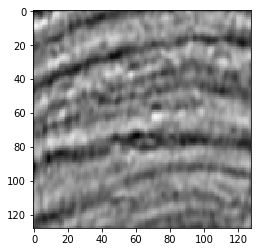

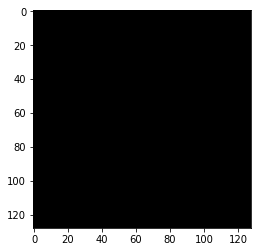

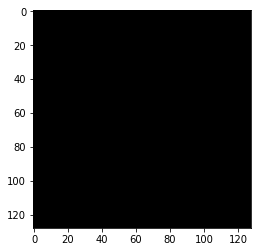

In [13]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [14]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}

In [15]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')